In [32]:
%matplotlib inline

import os

import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import geopandas as gpd
import rasterio

from shapely.geometry import Point
from rasterio.io import MemoryFile
from rasterio import features
from rasterio.plot import show, show_hist
from matplotlib import pyplot as plt



In [7]:
target_year = '2015'

# directory containing demeter input and output directories
demeter_dir = '/Users/d3y010/projects/msd_live/gcam_demeter_demo/demeter_data'

# directory containing Demeter's GCAM projected land allocation file
projected_dir = os.path.join(demeter_dir, 'inputs', 'projected')

# directory containing Demeter's outputs
demeter_output_dir = os.path.join(demeter_dir, 'outputs', 'example_2020-11-03_21h37m54s', 'spatial_landcover_tabular')

# demeter output file for the target year
demeter_lc_file = os.path.join(demeter_output_dir, f"landcover_{target_year}_timestep.csv")

# Demeter's GCAM projected land allocation file
gcam_projected_file = os.path.join(projected_dir, 'gcam_ref_scenario_reg32_basin235_v5p1p3.csv')

# a Pandas data frame of GCAM's projected land allocation data
gcam_df = pd.read_csv(gcam_projected_file)

# Demeter's output land allocation data
demeter_df = pd.read_csv(demeter_lc_file)

rast = '/Users/d3y010/Desktop/rast.tif'
dem_template = '/Users/d3y010/repos/github/im3vis/im3vis/data/demeter_conus_template.tif'


In [4]:
# extract the USA
demeter_usa_df = demeter_df.loc[demeter_df['region_id'] == 1].copy()

In [5]:
# create geometry column from coordinate fields
geometry = [Point(xy) for xy in zip(demeter_usa_df['longitude'], demeter_usa_df['latitude'])]

# coordinate reference system for WGS84
crs = 'epsg:4326'

gdf = gpd.GeoDataFrame(demeter_usa_df, crs=crs, geometry=geometry)

In [28]:
def write_memrast(metadata, shapes):
    """Write an in-memory rasterio object."""

    with MemoryFile() as memfile:

        dataset = memfile.open(**meta)

        out_arr = dataset.read(1)

        burned = features.rasterize(shapes=shapes, fill=meta['nodata'], out=out_arr, transform=dataset.transform)

        dataset.write_band(1, burned)
        
        return dataset

In [55]:
meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -99999.0,
 'width': 693,
 'height': 298,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.083333, 0.0, -124.6665025,
        0.0, -0.08333299999999999, 49.3333665),
 'compress': 'lzw'}

In [29]:
r = rasterio.open(dem_template)
meta = r.meta.copy()
meta.update(compress='lzw')

# this is where we create a generator of geom, value pairs to use in rasterizing
shapes = ((geom,value) for geom, value in zip(gdf.geometry, gdf['forest']))

ds = write_memrast(meta, shapes)

# write output to memory
# with MemoryFile() as memfile:
    
#     dataset = memfile.open(**meta)
    
#     out_arr = dataset.read(1)
    
#     # this is where we create a generator of geom, value pairs to use in rasterizing
#     shapes = ((geom,value) for geom, value in zip(gdf.geometry, gdf['forest']))
    
#     burned = features.rasterize(shapes=shapes, fill=meta['nodata'], out=out_arr, transform=dataset.transform)

#     dataset.write_band(1, burned)


with rasterio.open(rast, 'w+', **meta) as out:
    
    out_arr = out.read(1)
    
    # this is where we create a generator of geom, value pairs to use in rasterizing
    shapes = ((geom,value) for geom, value in zip(gdf.geometry, gdf['forest']))

    burned = features.rasterize(shapes=shapes, fill=meta['nodata'], out=out_arr, transform=out.transform)
    out.write_band(1, burned)
    


In [53]:
import tempfile
import seaborn as sns


def plot_conus_raster(boundary_file, demeter_gdf, landclass, metadata, target_year, font_scale=1.5):
    """Generate a raster plot from demeter outputs for the CONUS for a specified land class."""
    
    sns.set(font_scale=font_scale)
    
    # read in boundary data
    bdf = gpd.read_file(boundary_file)
    
    # generate a temporary file
    temp_file = tempfile.NamedTemporaryFile(suffix='.tif')
    rast = temp_file.name

    # create a generator of geom, value pairs to use in rasterizing
    shapes = ((geom, value) for geom, value in zip(demeter_gdf.geometry, demeter_gdf[landclass]))

    # burn point values in to raster
    with rasterio.open(rast, 'w+', **metadata) as out:

        out_arr = out.read(1)

        burned = features.rasterize(shapes=shapes, fill=meta['nodata'], out=out_arr, transform=out.transform)
        out.write_band(1, burned)    

    # open and visualize
    with rasterio.open(rast) as src:
        fig, ax = plt.subplots(1, figsize=(10, 4))

        bdf.geometry.boundary.plot(ax=ax, color='grey', lw=0.4)
        
        show(src, 
             cmap='YlGn', 
             ax=ax, 
             title=f"Demeter land allocation for {landclass} for {target_year}")
        ax.legend()
        
        return src


No handles with labels found to put in legend.


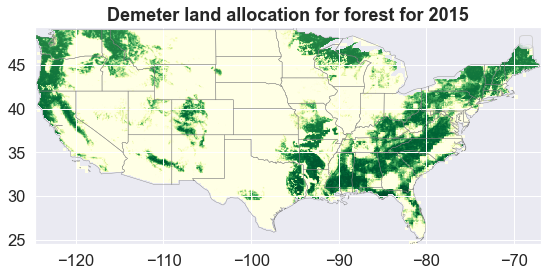

In [54]:
boundary_file = '/Users/d3y010/projects/gis/natural_earth/ne_50m_conus.shp'


r = plot_conus_raster(boundary_file, gdf, 'forest', meta, target_year)

In [24]:
gxf.basin_id.unique()

array([217, 222, 220, 223, 218, 228, 227, 233, 232, 229,  23,  27, 231,
       226, 225, 219, 221,  96, 224, 230])

<AxesSubplot:>

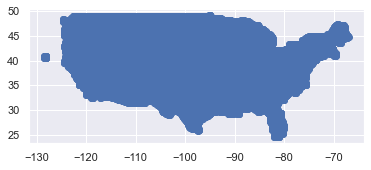

In [25]:
conus_basins = [217, 222, 220, 223, 218, 228, 227, 233, 232, 229, 23, 27, 
                231, 226, 225, 219, 221,  96, 224, 230]

conus_gdf = gdf.loc[gdf['basin_id'].isin(conus_basins)]
conus_gdf.geometry.plot()

In [80]:
bdf.head()

,name,geometry
0,Alabama,"MULTIPOLYGON (((-87.48951 30.37768, -87.51325 ..."
1,Arkansas,"POLYGON ((-89.70477 36.00157, -89.70932 35.983..."
2,Arizona,"POLYGON ((-109.04781 31.32788, -109.27477 31.3..."
3,California,"MULTIPOLYGON (((-114.61054 34.99112, -114.6109..."
4,Colorado,"POLYGON ((-109.04667 37.00085, -109.04665 37.2..."
